In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from dataclasses import dataclass
import yaml
import cv2
import math
import torch

In [2]:
PROTOTYPE_PATH = "prototypes/"
HNE_PATH = "/home/ct678/code/charm_data/aligned_hne"

In [3]:
prototype_paths = list(sorted(os.path.join(PROTOTYPE_PATH, filename) for filename in os.listdir(PROTOTYPE_PATH) if filename.endswith('.npz')))
num_prototypes = len(prototype_paths)
print(f"Found {num_prototypes} prototype files.")

Found 80 prototype files.


In [22]:
prototypes = []
for prototype_path in tqdm(prototype_paths, desc="Loading prototypes"):
    data = np.load(prototype_path, mmap_mode='r')['region']
    prototypes.append(data)
len(prototypes)

Loading prototypes: 100%|██████████| 80/80 [00:14<00:00,  5.37it/s]


80

In [ ]:
interesting_prototype_count = sum(np.load(prototype_path, mmap_mode='r')['region'][:, :, 0].sum() > 5 for prototype_path in prototype_paths)
print(f"Found {interesting_prototype_count} interesting prototypes.")

Found 80 prototypes.


In [24]:
@dataclass
class BoundingBox:
    index: int
    bounds: list[int]

In [25]:
bounding_box_data = []
with open(os.path.join(PROTOTYPE_PATH, "prototype_bounds.txt"), 'r') as f:
    for s in f:
        index_match = re.search(r'index=(\d+)', s)
        index = int(index_match.group(1)) if index_match else None

        # Extract bounds
        bounds_match = re.search(r'bounds=\[([^\]]+)\]', s)
        bounds = list(map(int, bounds_match.group(1).split(','))) if bounds_match else None
        bounding_box = BoundingBox(index=index, bounds=bounds)
        bounding_box_data.append(bounding_box)

In [26]:
config_file = "./configs/unet_segment_newdata.yaml"
with open(config_file, "r") as stream:
    conf = yaml.safe_load(stream)

In [27]:
def patchify(big_img, conf):
    # h, w, c = big_img.shape
    ph, pw = conf['training']['patch_size']
    sh, sw = conf['training']['stride']
    tmp_img = big_img.unfold(0, ph, sh).unfold(1, pw, sw)  # N1, N2, C, H, W
    tmp_img = tmp_img.reshape(
        tmp_img.shape[0] * tmp_img.shape[1], tmp_img.shape[2], ph, pw
    )
    return tmp_img

In [28]:
def expected_patchify_shape(big_img_shape, conf):
    h, w, c = big_img_shape
    ph, pw = conf['training']['patch_size']
    sh, sw = conf['training']['stride']
    # Calculate the number of patches along the height (N1)
    # N1 = floor((H - ph) / sh) + 1
    n1 = math.floor((h - ph) / sh) + 1
    # Calculate the number of patches along the width (N2)
    # N2 = floor((W - pw) / sw) + 1
    n2 = math.floor((w - pw) / sw) + 1
    # The final shape after reshape is (N1 * N2, C, ph, pw)
    num_patches = n1 * n2
    return (num_patches, c, ph, pw)

In [29]:
train_ids = conf['data']['train_ids']

In [30]:
def load_filtered_patches_raman(raman_id, conf):
    patient_id = raman_id.split('_')[0]
    raman_ref = np.load(f"/home/ct678/code/charm_data/{patient_id}/{raman_id}_SRS_corrected.npy", mmap_mode='r')
    patched_raman = patchify(torch.from_numpy(raman_ref), conf)
    # filter out background patches
    all_zero = torch.all(patched_raman == 0, dim=(1, 2, 3))
    ids_to_include = torch.where(~all_zero)[0]
    patched_raman = patched_raman[ids_to_include]
    return patched_raman, ids_to_include

In [31]:
def locate_sample_and_index(train_ids, bounding_box_index):
    current_index_start = 0
    for train_id in tqdm(train_ids):
        patched_raman, ids_to_include = load_filtered_patches_raman(train_id, conf)
        next_index_start = current_index_start + patched_raman.shape[0]
        if current_index_start <= bounding_box_index < next_index_start:
            located_sample = train_id
            index_within_sample = bounding_box_index - current_index_start
            return located_sample, index_within_sample, ids_to_include
        current_index_start = next_index_start
    raise ValueError(f"Bounding box index {bounding_box_index} not found in train IDs.")

In [32]:
def get_hne_bound(located_sample, index_within_sample, ids_to_include, bounding_box_bounds):
    hne_located = np.load(os.path.join(f"{HNE_PATH}", f"{located_sample}_align_hne.npy"), mmap_mode='r')
    hne_downsized = cv2.resize(hne_located, (hne_located.shape[1] // 2, hne_located.shape[0] // 2), interpolation=cv2.INTER_LINEAR)
    patched_hne = patchify(torch.from_numpy(hne_downsized), conf)
    patched_hne = patched_hne[ids_to_include]

    selected_patch = patched_hne[index_within_sample]
    selected_bound = selected_patch[:, bounding_box_bounds[0]:bounding_box_bounds[1], bounding_box_bounds[2]:bounding_box_bounds[3]]
    return selected_bound.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization

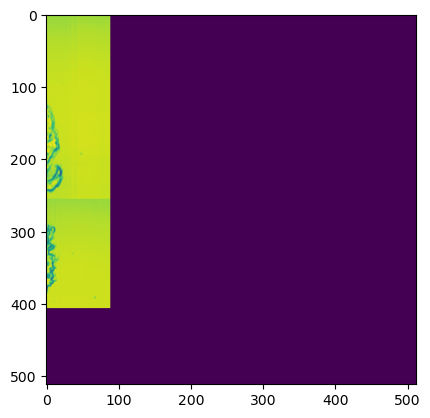

In [34]:
bounding_box = bounding_box_data[1]
plt.imshow(prototypes[1][:, :, 21])
plt.show()

In [35]:
located_sample, index_within_sample, ids_to_include = locate_sample_and_index(train_ids, bounding_box.index)

 53%|█████▎    | 10/19 [00:44<00:40,  4.49s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

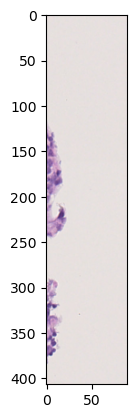

In [36]:
hne_bound = get_hne_bound(located_sample, index_within_sample, ids_to_include, bounding_box.bounds)
plt.imshow(hne_bound)
plt.show